In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
from itertools import cycle
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as met
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score
from sklearn.model_selection import cross_val_score, train_test_split 
%matplotlib inline

In [2]:
import tensorflow as tf

/home/d/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## convert categorical features

In [8]:
data = pd.read_csv('../loan.csv')

In [9]:
data = data[np.isfinite(data['amount'])]

In [10]:
data.amount[(Y==1)].value_counts()

NameError: name 'Y' is not defined

In [11]:
Y = data.loan_created

In [12]:
#last_fy_profit for most unapproved loans is a 5-dig amt
data.last_fy_profit[(Y==0) & (data.last_fy_profit.isnull())] = np.random.randint(10000,99999)

In [13]:
#company size = 10 has the highest approved chances, while company size = 11 has lesser cchance
data.loan_created[data.company_size==11].value_counts()

0.0    27
Name: loan_created, dtype: int64

In [14]:
data.company_size[(data.loan_created==1) & (data.company_size.isnull())]=10
data.company_size[(data.loan_created==0) & (data.company_size.isnull())]=11

/home/d/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
data.age_of_firm[(data.loan_created==0) & (data.age_of_firm.isnull())]=np.average(data.age_of_firm[(data.loan_created==0)].dropna())
data.age_of_firm[(data.loan_created==1) & (data.age_of_firm.isnull())]=np.average(data.age_of_firm[(data.loan_created==1)].dropna())

/home/d/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## orig_syn data

In [16]:
org_data = pd.read_csv('../data.csv')

In [17]:
org_Y = org_data.loan_created
org_X = org_data.drop(columns=['loan_created'])

In [18]:
org_Y.value_counts()

0    210
1      9
Name: loan_created, dtype: int64

In [19]:
syn_data = pd.read_csv('../syn_data.csv')

In [20]:
syn_data = syn_data.drop(columns='Unnamed: 0')

In [21]:
syn_Y = syn_data['loan_approved']
syn_X = syn_data.drop(columns = ['loan_approved'])

In [22]:
syn_Y.value_counts()

0    210
1     24
Name: loan_approved, dtype: int64

## feature analysis

### heatmap

In [23]:
syn_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 242 columns):
amount                                      float64
company_size                                float64
last_fy_profit                              float64
age_of_firm                                 float64
average_business_inflow                     float64
average_business_outflow                    float64
average_inflow                              float64
average_outflow                             float64
high_inflow_cp                              float64
inward_returns                              float64
max_business_inflow                         float64
max_business_outflow                        float64
max_inflow                                  float64
max_outflow                                 float64
min_business_inflow                         float64
min_business_outflow                        float64
min_inflow                                  float64
min_outflo

In [24]:
col = ['loan_approved','amount','min_business_outflow', 'high_inflow_cp', 'last_fy_profit',
       'average_business_inflow','min_business_inflow', 'average_inflow','max_business_outflow', 'max_inflow',
       'company_size', 'average_outflow']
hm_data = syn_data[col]

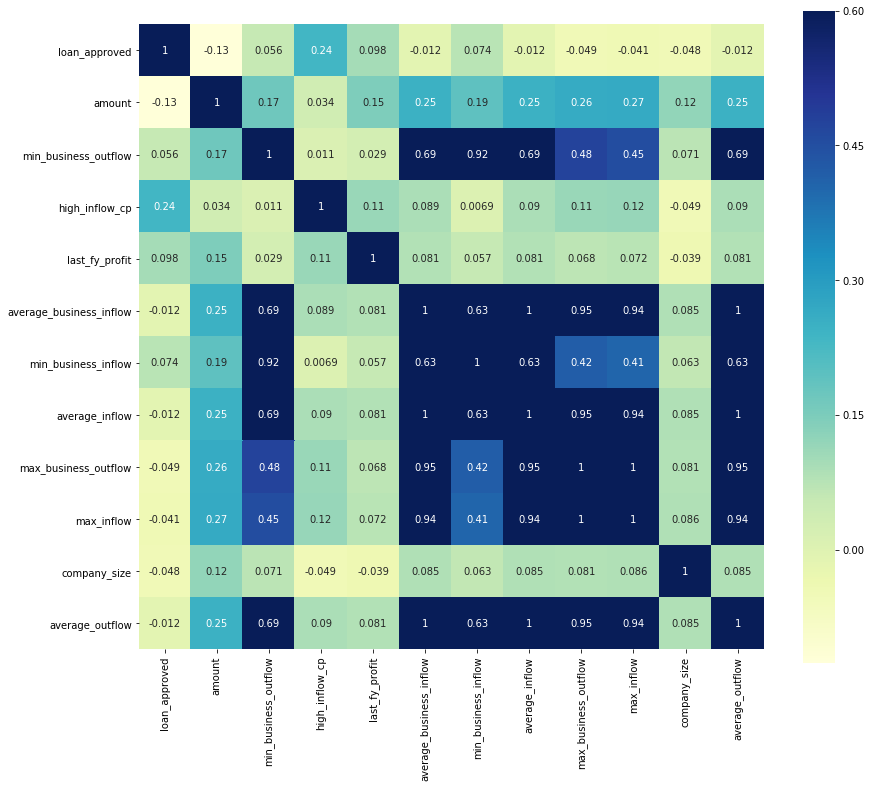

In [26]:
plt.figure(figsize=(14,12))
hm = sns.heatmap(hm_data.corr(), vmax=0.6, square=True, annot=True, cmap='YlGnBu')

In [27]:
clf = RandomForestClassifier(**model_params[0])

In [28]:
clf.fit(syn_X,syn_Y)

RandomForestClassifier(bootstrap=True, class_weight={0: 210, 1: 9},
            criterion='gini', max_depth=27, max_features='auto',
            max_leaf_nodes=11, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.2,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)

In [111]:
z = np.argsort(clf.feature_importances_)[::-1][:100]

In [112]:
fi = np.sort(clf.feature_importances_)[::-1]

In [113]:
cols = syn_X.columns

In [114]:
cols = pd.Series(cols[z], name = 'features')

In [231]:
cols_reduced = cols[:10]

In [232]:
cols_reduced = list(cols_reduced)

In [115]:
feature_imp = pd.concat([cols, pd.Series(fi, name= 'importance')], axis = 1)

In [281]:
feature_imp = feature_imp.loc[:15]

In [289]:
feature_imp.set_index('features',inplace=True)

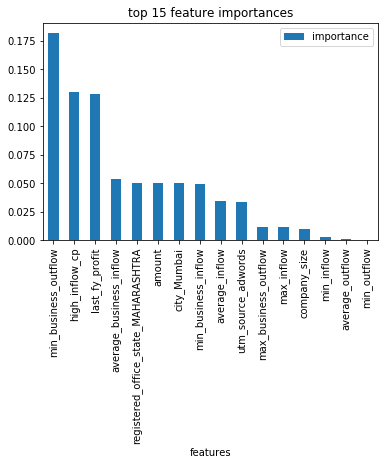

In [290]:
feature_imp.plot(kind='bar', title = 'top 15 feature importances', )

In [226]:
org_X_reduced = pd.DataFrame(data=org_X, columns=cols_reduced)

In [234]:
syn_X_reduced = pd.DataFrame(data=syn_X, columns=cols_reduced)

In [126]:
def scorer(clf, X, y, scoring='accuracy'):
    
    print('class: ',clf.class_weight)
    
    accuracy_ = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')
    print('Accuracy: ', np.average(accuracy_))
    
    f1_score_ = cross_val_score(clf, X, y, cv = 5, scoring = 'f1_macro')
    print('F1 score: ', np.average(f1_score_))
    
    auc_ =  cross_val_score(clf, X, y, cv=5, scoring = 'roc_auc')
    print('AUC: ', np.average(auc_))
    
    print('\n\n')
    
    return accuracy_, f1_score_, auc_
    

## original data

In [357]:
model_params = {}
model_params[0] = {'random_state': 87}
model_params[1] = {'max_depth': 27,
                'max_features': 'sqrt', 
                'max_leaf_nodes': None,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'n_estimators': 20,
                'random_state': 87}
model_params[2] = {'max_depth': 27,
                'max_features': 'sqrt', 
                'max_leaf_nodes': None,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'n_estimators': 20,
                'random_state': 87,
                'class_weight': {0:210, 1:24}}
model_params[3] = {'max_depth': 27,
                'max_features': 'sqrt', 
                'max_leaf_nodes': None,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'n_estimators': 20,
                'random_state': 87,
                'class_weight': 'balanced'}

In [359]:
model_params_og = {}
model_params_og[0] = {'random_state': 44}
model_params_og[1] = {'max_depth': 11,
                'max_features': 'log2', 
                'max_leaf_nodes': 9,
                'min_samples_leaf': 4,
                'min_samples_split': 12,
                'n_estimators': 10,
                'random_state': 44}
model_params_og[2] = {'max_depth': 11,
                'max_features': 'log2', 
                'max_leaf_nodes': 9,
                'min_samples_leaf': 4,
                'min_samples_split': 12,
                'n_estimators': 10,
                'random_state': 44,
                'class_weight': {0:210, 1:9}}
model_params_og[3] = {'max_depth': 11,
                'max_features': 'log2', 
                'max_leaf_nodes': 9,
                'min_samples_leaf': 4,
                'min_samples_split': 12,
                'n_estimators': 10,
                'random_state': 44,
                'class_weight': 'balanced'}

In [199]:
n_models = 4

In [121]:
import warnings; warnings.simplefilter('ignore')

## Original data : Gridcv

In [360]:
o_accuracy = {}
o_f1 = {}
o_auc = {}
for i in range(n_models):
    print('ORIGINAL DATA')
    clf = RandomForestClassifier(**model_params_og[i])
    acc, f1, auc = scorer(clf, org_X, org_Y)
    o_accuracy[i] = acc
    o_f1[i] = f1
    o_auc[i] = auc

ORIGINAL DATA
class:  None
Accuracy:  0.958985200845666
F1 score:  0.48952120383036934
AUC:  0.47738095238095235



ORIGINAL DATA
class:  None
Accuracy:  0.958985200845666
F1 score:  0.48952120383036934
AUC:  0.5440476190476191



ORIGINAL DATA
class:  {0: 210, 1: 9}
Accuracy:  0.958985200845666
F1 score:  0.48952120383036934
AUC:  0.5988095238095237



ORIGINAL DATA
class:  balanced
Accuracy:  0.9317124735729386
F1 score:  0.48221223373070166
AUC:  0.5678571428571428





In [233]:
o_accuracy = {}
o_f1 = {}
o_auc = {}
for i in range(n_models):
    print('ORIGINAL DATA')
    clf = RandomForestClassifier(**model_params[i])
    acc, f1, auc = scorer(clf, org_X_reduced, org_Y)
    o_accuracy[i] = acc
    o_f1[i] = f1
    o_auc[i] = auc

ORIGINAL DATA
class:  None
Accuracy:  0.9544397463002113
F1 score:  0.48831737346101234
AUC:  0.4809523809523809



ORIGINAL DATA
class:  None
Accuracy:  0.958985200845666
F1 score:  0.48952120383036934
AUC:  0.5202380952380953



ORIGINAL DATA
class:  {0: 210, 1: 9}
Accuracy:  0.9544397463002113
F1 score:  0.48831737346101234
AUC:  0.5273809523809525



ORIGINAL DATA
class:  balanced
Accuracy:  0.958985200845666
F1 score:  0.48952120383036934
AUC:  0.5630952380952381





## SMOTE : Gridcv

In [358]:
s_accuracy = {}
s_f1 = {}
s_auc = {}
for i in range(n_models):
    print('SMOTE DATA')
    
    clf = RandomForestClassifier(**model_params[i])
    acc, f1, auc = scorer(clf, syn_X, syn_Y)
    s_accuracy[i] = acc
    s_f1[i] = f1
    s_auc[i] = auc

SMOTE DATA
class:  None
Accuracy:  0.9574468085106382
F1 score:  0.8428692969739717
AUC:  0.9461904761904762



SMOTE DATA
class:  None
Accuracy:  0.9531914893617021
F1 score:  0.8179625944810625
AUC:  0.9638095238095239



SMOTE DATA
class:  {0: 210, 1: 24}
Accuracy:  0.9617021276595743
F1 score:  0.8579072966699742
AUC:  0.9876190476190476



SMOTE DATA
class:  balanced
Accuracy:  0.9617021276595743
F1 score:  0.8452881758764113
AUC:  0.9338095238095239





## feature reduce

In [237]:
s_accuracy = {}
s_f1 = {}
s_auc = {}
for i in range(n_models):
    print('SMOTE DATA')
    clf = RandomForestClassifier(**model_params[i])
    acc, f1, auc = scorer(clf, syn_X_reduced, syn_Y)
    s_accuracy[i] = acc
    s_f1[i] = f1
    s_auc[i] = auc

SMOTE DATA
class:  None
Accuracy:  0.9319148936170212
F1 score:  0.7435373146123654
AUC:  0.93



SMOTE DATA
class:  None
Accuracy:  0.948936170212766
F1 score:  0.80292459478506
AUC:  0.930952380952381



SMOTE DATA
class:  {0: 210, 1: 24}
Accuracy:  0.948936170212766
F1 score:  0.80292459478506
AUC:  0.9161904761904761



SMOTE DATA
class:  balanced
Accuracy:  0.948936170212766
F1 score:  0.7917766285035318
AUC:  0.9295238095238094





## Plot roc

In [270]:
n_samples, n_features = syn_X.shape

In [271]:
random_state = np.random.RandomState(0)

In [272]:
X = np.c_[syn_X, random_state.randn(n_samples,  n_features)]

TypeError: randn() argument after * must be an iterable, not int

In [364]:
# text = ['Default RF','GridSearch RF', 'GridSearch+Weighted RF', 'GridSearch+Balanced RF']

# plt.figure(figsize=(12,18))
# for i in range(4):
#     cv = StratifiedKFold(n_splits=5)
#     classifier = RandomForestClassifier(**model_params[i])
#     plot_auc(classifier, text[i], i)

In [430]:

def plot_auc(classifier, text,pt):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    plt.subplot(4,2,pt+1)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for train, test in cv.split(syn_X, syn_Y):
    #     print(train,test)
        probas_ = classifier.fit(syn_X.iloc[train], syn_Y[train]).predict_proba(syn_X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(syn_Y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = met.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = met.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic :\n '+text)
    plt.legend(loc="lower right", prop={'size':8})